In [38]:
import numpy as np
import sys
import tensorflow as tf
import argparse
import heapq
import math

In [39]:
parser = argparse.ArgumentParser(description="Options")

In [40]:
parser.add_argument('-dataName', action='store', dest='dataName', default='miRNA-disease')

_StoreAction(option_strings=['-dataName'], dest='dataName', nargs=None, const=None, default='miRNA-disease', type=None, choices=None, help=None, metavar=None)

In [41]:
parser.add_argument('-negNum', action='store', dest='negNum', default=1, type=int)

_StoreAction(option_strings=['-negNum'], dest='negNum', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help=None, metavar=None)

In [42]:
parser.add_argument('-userLayer', action='store', dest='userLayer', default=[32,16])

_StoreAction(option_strings=['-userLayer'], dest='userLayer', nargs=None, const=None, default=[32, 16], type=None, choices=None, help=None, metavar=None)

In [43]:
parser.add_argument('-itemLayer', action='store', dest='itemLayer', default=[32,16])

_StoreAction(option_strings=['-itemLayer'], dest='itemLayer', nargs=None, const=None, default=[32, 16], type=None, choices=None, help=None, metavar=None)

In [44]:
parser.add_argument('-userFLayer', action='store', dest='userFLayer', default=[32,16])

_StoreAction(option_strings=['-userFLayer'], dest='userFLayer', nargs=None, const=None, default=[32, 16], type=None, choices=None, help=None, metavar=None)

In [45]:
#parser.add_argument('-itemFLayer', action='store', dest='itemFLayer', default=[128, 32])
parser.add_argument('-reg', action='store', dest='reg', default=0.5)

_StoreAction(option_strings=['-reg'], dest='reg', nargs=None, const=None, default=0.5, type=None, choices=None, help=None, metavar=None)

In [46]:
parser.add_argument('-alfha', action='store',dest='alfha',default = 0.7)

_StoreAction(option_strings=['-alfha'], dest='alfha', nargs=None, const=None, default=0.7, type=None, choices=None, help=None, metavar=None)

In [47]:
parser.add_argument('-lr', action='store', dest='lr', default=0.00001)

_StoreAction(option_strings=['-lr'], dest='lr', nargs=None, const=None, default=1e-05, type=None, choices=None, help=None, metavar=None)

In [48]:
parser.add_argument('-maxEpochs', action='store', dest='maxEpochs', default=400, type=int)

_StoreAction(option_strings=['-maxEpochs'], dest='maxEpochs', nargs=None, const=None, default=400, type=<class 'int'>, choices=None, help=None, metavar=None)

In [49]:
parser.add_argument('-batchSize', action='store', dest='batchSize', default=5000, type=int)

_StoreAction(option_strings=['-batchSize'], dest='batchSize', nargs=None, const=None, default=5000, type=<class 'int'>, choices=None, help=None, metavar=None)

In [50]:
parser.add_argument('-earlyStop', action='store', dest='earlyStop', default=20)

_StoreAction(option_strings=['-earlyStop'], dest='earlyStop', nargs=None, const=None, default=20, type=None, choices=None, help=None, metavar=None)

In [51]:
#parser.add_argument('-checkPoint', action='store', dest='checkPoint', default='./checkPoint/')
parser.add_argument('-topK', action='store', dest='topK', default=10)

_StoreAction(option_strings=['-topK'], dest='topK', nargs=None, const=None, default=10, type=None, choices=None, help=None, metavar=None)

In [52]:
parser.add_argument('-cvfold', action='store', dest='cvfold', default=2)

_StoreAction(option_strings=['-cvfold'], dest='cvfold', nargs=None, const=None, default=2, type=None, choices=None, help=None, metavar=None)

In [53]:
parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [54]:
args = parser.parse_args()

In [55]:
args

Namespace(alfha=0.7, batchSize=5000, cvfold=2, dataName='miRNA-disease', earlyStop=20, f='/root/.local/share/jupyter/runtime/kernel-f6d0adb4-9435-4d66-9dd2-bffb57873709.json', itemLayer=[32, 16], lr=1e-05, maxEpochs=400, negNum=1, reg=0.5, topK=10, userFLayer=[32, 16], userLayer=[32, 16])

In [56]:
#generate 5-fold training list
# the total number of miRNA-disease associations
training_samples_num = 11252

In [57]:
fold_num = args.cvfold
# convert the number to a list
l = np.arange(training_samples_num)
# shuffle the list
np.random.shuffle(l)

In [58]:
fold_num

2

In [59]:
class DataSet:
    def __init__(self, fileName, Testinglist):
        self.data, self.shape = self.getData(fileName)
        self.userdata, self.UF_len = self.getFeatureData()
        self.train, self.test = self.getTrainTest(Testinglist)
        self.trainDict = self.getTrainDict()
        self.testDict = self.getTestDict()

    def getData(self, fileName):
        if fileName == 'miRNA-disease':
            print("Loading lncRNA-miRNA data set...")
            data = []
            filePath = '../data/MVMTMDA/miRNA-disease_id.txt'
#             filePath = './Data/ml-1m/ratings.dat'
            u = 0
            i = 0
            maxr = 0.0
            with open(filePath, 'r') as f:
                for line in f:
                    if line:
                        lines = line[:-1].split("::")
                        user = int(lines[0])
                        movie = int(lines[1])
                        score = float(lines[2])
                        data.append((user, movie, score))
                        if user > u:
                            u = user
                        if movie > i:
                            i = movie
                        if score > maxr:
                            maxr = score
            self.maxRate = maxr
            print("Loading Success!\n"
                  "Data Info:\n"
                  "\tUser Num: {}\n"
                  "\tItem Num: {}\n"
                  "\tData Size: {}".format(u, i, len(data)))
            return data, [u, i]
        else:
            print("Current data set is not support!")
            sys.exit()
    
    def getFeatureData(self):
        UserFeature_data = []
        filePath_U = '../data/MVMTMDA/lncRNA-miRNA_id.txt'
        UF_len = 0
        with open(filePath_U,'r') as f_u:
            for line in f_u:
                if line:
                    lines = line[:-1].split("::")
                    user = int(lines[1])
                    user_f = int(lines[0])
                    score = float(lines[2])
                    UserFeature_data.append((user,user_f,score))
                    if user_f > UF_len:
                        UF_len = user_f
        print("Loading Feature Success! \n"
                  "\tUser feature length: {}\n".format(UF_len))
        return UserFeature_data, UF_len

    def getTrainTest(self, Testinglist):
        data = self.data
        train = []
        test = []
        for i in range(len(data)):             
            user = data[i][0]-1
            item = data[i][1]-1
            rate = data[i][2]
            if i in Testinglist:
                test.append((user, item, rate))            
            else:
                train.append((user, item, rate))        
        return train, test
    

    def getTrainDict(self):
        dataDict = {}
        for i in self.train:
            dataDict[(i[0], i[1])] = i[2]
        return dataDict
    
    def getTestDict(self):
        dataDict = {}
        for i in self.test:
            dataDict[(i[0], i[1])] = i[2]
        return dataDict

    def getEmbedding(self):
        train_matrix = np.zeros([self.shape[0], self.shape[1]], dtype=np.float32)
        for i in self.train:
            user = i[0]
            movie = i[1]
            rating = i[2]
            train_matrix[user][movie] = rating
        return np.array(train_matrix)
    
    def getFeatureEmbedding(self):
        UserFeature_matrix = np.zeros([self.shape[0], self.UF_len], dtype=np.float32) 
        
        for i in self.userdata:
            user = i[0]-1
            u_feature = i[1]-1
            rating = i[2]
            UserFeature_matrix[user][u_feature] = rating
            
        
        return np.array(UserFeature_matrix)

    def getInstances(self, data, negNum):
        user = []
        item = []
        rate = []
        for i in data:
            user.append(i[0])
            item.append(i[1])
            rate.append(i[2])
            for t in range(negNum):
                j = np.random.randint(self.shape[1])
                while (i[0], j) in self.trainDict:
                    j = np.random.randint(self.shape[1])
                user.append(i[0])
                item.append(j)
                rate.append(0.0)
        return np.array(user), np.array(item), np.array(rate)
    
    
    #getTrainAll: return training data along with other candidates
    def getTrainAll(self):
        TrainDict = self.getTrainDict()
        user = []
        item = []
        rate = []
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                user.append(i)
                item.append(j)
                if (i,j) in TrainDict:
                    rate.append(1)
                else:
                    rate.append(0)
        return np.array(user), np.array(item), np.array(rate)

    #negNum: number of negative samples for each user
    def getTestNeg(self, testData, negNum):
        user = []
        item = []
        for s in testData:
            tmp_user = []
            tmp_item = []
            u = s[0]
            i = s[1]
            tmp_user.append(u)
            tmp_item.append(i)
            neglist = set()
            neglist.add(i)
            for t in range(negNum):
                j = np.random.randint(self.shape[1])
                while (u, j) in self.trainDict or j in neglist:
                    j = np.random.randint(self.shape[1])
                neglist.add(j)
                tmp_user.append(u)
                tmp_item.append(j)
            user.append(tmp_user)
            item.append(tmp_item)
        return [np.array(user), np.array(item)]


In [60]:
class Model:
    def __init__(self, args, Testinglist):
        self.dataName = args.dataName
        self.dataSet = DataSet(self.dataName, Testinglist)
        self.shape = self.dataSet.shape
        self.maxRate = self.dataSet.maxRate
        
        self.userFlen = self.dataSet.UF_len
        self.allMatrix = self.dataSet.getTrainAll()
        
        self.train = self.dataSet.train
        self.test = self.dataSet.test

        self.negNum = args.negNum
        self.reg = args.reg
        self.alfha = args.alfha
        self.testNeg = self.dataSet.getTestNeg(self.test, 20)
        
        self.cvfold_num = args.cvfold
        
        self.add_embedding_matrix()
        print("add_embedding_matrix SUCCESS")
        self.add_placeholders()
        print("add_placeholders SUCCESS")

        self.userLayer = args.userLayer
        self.itemLayer = args.itemLayer
        self.userFLayer = args.userFLayer
        self.add_model()
        print("add_model SUCCESS")

        self.add_loss()
        print("add_loss SUCCESS")

        self.lr = args.lr
        self.add_train_step()
        print("add_train_step SUCCESS")

#         self.checkPoint = args.checkPoint
        self.init_sess()
        print("init_sess SUCCESS")

        self.maxEpochs = args.maxEpochs
        self.batchSize = args.batchSize

        self.topK = args.topK
        self.earlyStop = args.earlyStop
        
    def add_placeholders(self):
        self.user = tf.placeholder(tf.int32)
        self.item = tf.placeholder(tf.int32)
        self.rate = tf.placeholder(tf.float32)

    def add_embedding_matrix(self):
        self.user_item_embedding = tf.convert_to_tensor(self.dataSet.getEmbedding())
        self.item_user_embedding = tf.transpose(self.user_item_embedding)
        user_feature = self.dataSet.getFeatureEmbedding()
        self.user_feature_embedding = tf.convert_to_tensor(user_feature)
        self.feature_user_embedding = tf.transpose(tf.convert_to_tensor(user_feature))

    def add_model(self):
        user_input = tf.nn.embedding_lookup(self.user_item_embedding, self.user)
        item_input = tf.nn.embedding_lookup(self.item_user_embedding, self.item)
        Fea_user_input = self.feature_user_embedding
        userFea_input = tf.nn.embedding_lookup(self.user_feature_embedding, self.user) 

        def init_variable(shape, name):
            return tf.Variable(tf.truncated_normal(shape=shape, dtype=tf.float32, stddev=0.01), name=name)

        with tf.name_scope("User_Layer"):
            user_W1 = init_variable([self.shape[1], self.userLayer[0]], "user_W1")
            user_out = tf.matmul(user_input, user_W1)
            for i in range(0, len(self.userLayer)-1):
                W = init_variable([self.userLayer[i], self.userLayer[i+1]], "user_W"+str(i+2))
                b = init_variable([self.userLayer[i+1]], "user_b"+str(i+2))
                user_out = tf.nn.relu(tf.add(tf.matmul(user_out, W), b))

        with tf.name_scope("Item_Layer"):
            item_W1 = init_variable([self.shape[0], self.itemLayer[0]], "item_W1")
            item_out = tf.matmul(item_input, item_W1)
            for i in range(0, len(self.itemLayer)-1):
                W = init_variable([self.itemLayer[i], self.itemLayer[i+1]], "item_W"+str(i+2))
                b = init_variable([self.itemLayer[i+1]], "item_b"+str(i+2))
                item_out = tf.nn.relu(tf.add(tf.matmul(item_out, W), b))

        with tf.name_scope("UserFeature_Layer"):
            userF_W1 = init_variable([self.shape[0], self.userFLayer[0]], "userF_W1")
            userF_out = tf.matmul(Fea_user_input, userF_W1)
            for i in range(0, len(self.userFLayer)-1):
                W = init_variable([self.userFLayer[i], self.userFLayer[i+1]], "userF_W"+str(i+2))
                b = init_variable([self.userFLayer[i+1]], "userF_b"+str(i+2))
                userF_out = tf.nn.relu(tf.add(tf.matmul(userF_out, W), b))                
        
        norm_user_output = tf.norm(user_out, axis=1)
        norm_item_output = tf.norm(item_out, axis=1)        
        norm_userF_output = tf.norm(userF_out)
        
        self.y_ = tf.reduce_sum(tf.multiply(user_out, item_out), axis=1, keep_dims=False) / (norm_item_output* norm_user_output)        
               
        self.user_out = user_out
        self.yu_ = tf.matmul(userF_out, tf.transpose(user_out)) / (norm_user_output* norm_userF_output)             
        
        self.y_ = tf.maximum(1e-6, self.y_)
        self.yu_ = tf.maximum(1e-6, self.yu_)
                
        self.y_ = tf.minimum(1-1e-6, self.y_)
        self.yu_ = tf.minimum(1-1e-6, self.yu_)
                
        self.yu_temp = tf.subtract(self.yu_, tf.transpose(userFea_input))

    def add_loss(self):
        regRate = self.rate / self.maxRate
             
        losses = regRate * tf.log(self.y_) + (1 - regRate) * tf.log(1 - self.y_)
        loss = -tf.reduce_sum(losses)

        #MSE
        losses_u = tf.reduce_mean(tf.square(self.yu_temp)) / self.dataSet.UF_len
        t_vars = tf.trainable_variables()
        self.loss = loss * self.alfha + self.reg * tf.add_n([tf.nn.l2_loss(v) for v in t_vars if v.name.startswith('Item_Layer')]) + 0.5 * tf.add_n([tf.nn.l2_loss(v) for v in t_vars if v.name.startswith('User_Layer')])
        self.loss_u = losses_u * (1-self.alfha) + self.reg * tf.add_n([tf.nn.l2_loss(v) for v in t_vars if v.name.startswith('UserFeature_Layer')]) + 0.5 * tf.add_n([tf.nn.l2_loss(v) for v in t_vars if v.name.startswith('User_Layer')])
    def add_train_step(self):
        '''
        global_step = tf.Variable(0, name='global_step', trainable=False)
        self.lr = tf.train.exponential_decay(self.lr, global_step,
                                             self.decay_steps, self.decay_rate, staircase=True)
        '''
        t_vars = tf.trainable_variables()
        var_list1 = []
        var_list2 = []
        for v in t_vars:
            if v.name.startswith('Item_Layer') or v.name.startswith('User_Layer'):
                var_list2.append(v)
        for v in t_vars:
            if v.name.startswith('UserFeature_Layer') or v.name.startswith('User_Layer'):
                var_list1.append(v)
        
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step1 = optimizer.minimize(self.loss_u, var_list = var_list1)
        self.train_step2 = optimizer.minimize(self.loss, var_list = var_list2)

    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())


    def run(self):
        loss_epoch = []
        loss_u_epoch = []
        print("Start Training!")
        for epoch in range(self.maxEpochs):
            print("="*20+"Epoch ", epoch, "="*20)
            loss, loss_u = self.run_epoch(self.sess)
            loss_epoch.append(loss)
            loss_u_epoch.append(loss_u)
            print('='*50)
        s_ItemUser, s_UserF, s_UserEmbedding = self.get_testScore(self.sess)
        return s_ItemUser, s_UserF, s_UserEmbedding

    def run_epoch(self, sess, verbose=10):
        train_u, train_i, train_r = self.dataSet.getInstances(self.train, self.negNum)
        train_len = len(train_u)
        shuffled_idx = np.random.permutation(np.arange(train_len))
        train_u = train_u[shuffled_idx]
        train_i = train_i[shuffled_idx]
        train_r = train_r[shuffled_idx]

        num_batches = len(train_u) // self.batchSize + 1

        losses = []
        losses_u = []
        for i in range(num_batches):
            min_idx = i * self.batchSize
            max_idx = np.min([train_len, (i+1)*self.batchSize])
            train_u_batch = train_u[min_idx: max_idx]
            train_i_batch = train_i[min_idx: max_idx]
            train_r_batch = train_r[min_idx: max_idx]

            feed_dict = self.create_feed_dict(train_u_batch, train_i_batch, train_r_batch)
            _, _, tmp_loss, tmp_loss_u = sess.run([self.train_step1, self.train_step2, self.loss, self.loss_u], feed_dict=feed_dict)
#             _, tmp_loss, tmp_loss_u = sess.run([self.train_step2, self.loss, self.loss_u], feed_dict=feed_dict)
            losses.append(tmp_loss)
            losses_u.append(tmp_loss_u)
            if verbose and i % verbose == 0:
                if np.isnan(np.mean(losses[-verbose:])):
                    raise ValueError                                
                sys.stdout.write('\r{} / {} : loss = {}'.format(
                    i, num_batches, np.mean(losses[-verbose:])
                ))
                sys.stdout.flush()
        loss = np.mean(losses)
        loss_u = np.mean(losses_u)
        print("\nMean loss in this epoch is: {}".format(loss))
        return loss, loss_u

    def create_feed_dict(self, u, i, r=None):
        return {self.user: u,
                self.item: i,
                self.rate: r,}

    def evaluate(self, sess, topK):
        def getHitRatio(ranklist, targetItem):
            for item in ranklist:
                if item == targetItem:
                    return 1
            return 0
        def getNDCG(ranklist, targetItem):
            for i in range(len(ranklist)):
                item = ranklist[i]
                if item == targetItem:
                    return math.log(2) / math.log(i+2)
            return 0

        hr =[]
        NDCG = []
        testUser = self.testNeg[0]
        testItem = self.testNeg[1]
        for i in range(len(testUser)):
            target = testItem[i][0]
            feed_dict = self.create_feed_dict(testUser[i], testItem[i])
            predict = sess.run(self.y_, feed_dict=feed_dict)
            item_score_dict = {}

            for j in range(len(testItem[i])):
                item = testItem[i][j]
                item_score_dict[item] = predict[j]

            ranklist = heapq.nlargest(topK, item_score_dict, key=item_score_dict.get)

            tmp_hr = getHitRatio(ranklist, target)
            tmp_NDCG = getNDCG(ranklist, target)
            hr.append(tmp_hr)
            NDCG.append(tmp_NDCG)
        return np.mean(hr), np.mean(NDCG)
    
    def get_testScore(self, sess):
        train_allu = self.allMatrix[0]
        train_alli = self.allMatrix[1]
        train_allr = self.allMatrix[2]
        feed_dict = self.create_feed_dict(train_allu, train_alli, train_allr)
        predict_p, predict_q, predict_user_out = sess.run([self.y_, self.yu_, self.user_out], feed_dict=feed_dict)
        
        
        s_ItemUser = np.zeros((799, 268))
        for i in range(len(predict_p)):
            s_ItemUser[train_alli[i],train_allu[i]] = predict_p[i]
        
        
        print(predict_user_out.shape)
        s_UserEmbedding = np.zeros((268, predict_user_out.shape[1]))
         #to get the score of userFeature matrix        
        s_UserF = np.zeros((541, 268))
        u_set = set()
        for i in range(predict_q.shape[1]):
            if train_allu[i] not in u_set:
                s_UserF[:,train_allu[i]] = predict_q[:, i]
                s_UserEmbedding[train_allu[i],:] = predict_user_out[i, :]
                u_set.add(train_allu[i])
        
        return s_ItemUser, s_UserF, s_UserEmbedding

In [61]:
Testinglist = []             

classifier = Model(args,Testinglist)
s_ItemUser, s_UserF, s_UserEmbedding  = classifier.run()
np.savetxt('s_LMI.txt',s_ItemUser)
np.savetxt('s_MDA.txt',s_UserF)
np.savetxt('s_MicroRNA_Embedding.txt',s_UserEmbedding)

Loading lncRNA-miRNA data set...
Loading Success!
Data Info:
	User Num: 268
	Item Num: 799
	Data Size: 11252
Loading Feature Success! 
	User feature length: 541

add_embedding_matrix SUCCESS
add_placeholders SUCCESS
add_model SUCCESS
add_loss SUCCESS
add_train_step SUCCESS
init_sess SUCCESS
Start Training!
====================Epoch  0 ====================
0 / 5 : loss = 2462.306884765625
Mean loss in this epoch is: 2203.274658203125
====================Epoch  1 ====================
0 / 5 : loss = 2406.5283203125
Mean loss in this epoch is: 2151.822509765625
====================Epoch  2 ====================
0 / 5 : loss = 2357.778564453125
Mean loss in this epoch is: 2111.03076171875
====================Epoch  3 ====================
0 / 5 : loss = 2328.205810546875
Mean loss in this epoch is: 2069.09326171875
====================Epoch  4 ====================
0 / 5 : loss = 2271.385986328125
Mean loss in this epoch is: 2027.302734375
====================Epoch  5 ====================
0 / 

0 / 5 : loss = 1576.15966796875
Mean loss in this epoch is: 1432.8233642578125
====================Epoch  45 ====================
0 / 5 : loss = 1590.4786376953125
Mean loss in this epoch is: 1432.787353515625
====================Epoch  46 ====================
0 / 5 : loss = 1582.446044921875
Mean loss in this epoch is: 1426.0816650390625
====================Epoch  47 ====================
0 / 5 : loss = 1596.2276611328125
Mean loss in this epoch is: 1446.6546630859375
====================Epoch  48 ====================
0 / 5 : loss = 1608.1014404296875
Mean loss in this epoch is: 1429.98193359375
====================Epoch  49 ====================
0 / 5 : loss = 1599.5155029296875
Mean loss in this epoch is: 1438.635009765625
====================Epoch  50 ====================
0 / 5 : loss = 1637.6826171875
Mean loss in this epoch is: 1445.18701171875
====================Epoch  51 ====================
0 / 5 : loss = 1551.03076171875
Mean loss in this epoch is: 1427.6322021484375
=========

0 / 5 : loss = 1548.1566162109375
Mean loss in this epoch is: 1380.616943359375
====================Epoch  91 ====================
0 / 5 : loss = 1535.3759765625
Mean loss in this epoch is: 1393.246337890625
====================Epoch  92 ====================
0 / 5 : loss = 1549.5693359375
Mean loss in this epoch is: 1382.20849609375
====================Epoch  93 ====================
0 / 5 : loss = 1523.0936279296875
Mean loss in this epoch is: 1388.0684814453125
====================Epoch  94 ====================
0 / 5 : loss = 1596.04736328125
Mean loss in this epoch is: 1386.61181640625
====================Epoch  95 ====================
0 / 5 : loss = 1536.0911865234375
Mean loss in this epoch is: 1398.893798828125
====================Epoch  96 ====================
0 / 5 : loss = 1522.9698486328125
Mean loss in this epoch is: 1395.9298095703125
====================Epoch  97 ====================
0 / 5 : loss = 1577.75634765625
Mean loss in this epoch is: 1401.0877685546875
============

0 / 5 : loss = 1552.6177978515625
Mean loss in this epoch is: 1372.9095458984375
====================Epoch  136 ====================
0 / 5 : loss = 1440.1907958984375
Mean loss in this epoch is: 1378.277099609375
====================Epoch  137 ====================
0 / 5 : loss = 1541.543701171875
Mean loss in this epoch is: 1350.9599609375
====================Epoch  138 ====================
0 / 5 : loss = 1506.873291015625
Mean loss in this epoch is: 1378.952392578125
====================Epoch  139 ====================
0 / 5 : loss = 1533.8289794921875
Mean loss in this epoch is: 1379.5863037109375
====================Epoch  140 ====================
0 / 5 : loss = 1537.4674072265625
Mean loss in this epoch is: 1359.5386962890625
====================Epoch  141 ====================
0 / 5 : loss = 1481.281982421875
Mean loss in this epoch is: 1370.2396240234375
====================Epoch  142 ====================
0 / 5 : loss = 1525.7745361328125
Mean loss in this epoch is: 1371.8400878906

0 / 5 : loss = 1465.5867919921875
Mean loss in this epoch is: 1359.7308349609375
====================Epoch  181 ====================
0 / 5 : loss = 1490.728271484375
Mean loss in this epoch is: 1350.4151611328125
====================Epoch  182 ====================
0 / 5 : loss = 1505.2955322265625
Mean loss in this epoch is: 1357.2154541015625
====================Epoch  183 ====================
0 / 5 : loss = 1524.7891845703125
Mean loss in this epoch is: 1353.333251953125
====================Epoch  184 ====================
0 / 5 : loss = 1487.46826171875
Mean loss in this epoch is: 1356.030517578125
====================Epoch  185 ====================
0 / 5 : loss = 1440.9407958984375
Mean loss in this epoch is: 1339.4144287109375
====================Epoch  186 ====================
0 / 5 : loss = 1503.0137939453125
Mean loss in this epoch is: 1351.4554443359375
====================Epoch  187 ====================
0 / 5 : loss = 1468.9102783203125
Mean loss in this epoch is: 1338.0798339

0 / 5 : loss = 1443.6761474609375
Mean loss in this epoch is: 1338.530029296875
====================Epoch  226 ====================
0 / 5 : loss = 1477.8001708984375
Mean loss in this epoch is: 1326.64794921875
====================Epoch  227 ====================
0 / 5 : loss = 1455.3878173828125
Mean loss in this epoch is: 1326.83837890625
====================Epoch  228 ====================
0 / 5 : loss = 1477.836669921875
Mean loss in this epoch is: 1329.8348388671875
====================Epoch  229 ====================
0 / 5 : loss = 1486.1351318359375
Mean loss in this epoch is: 1330.068603515625
====================Epoch  230 ====================
0 / 5 : loss = 1472.8948974609375
Mean loss in this epoch is: 1335.0330810546875
====================Epoch  231 ====================
0 / 5 : loss = 1521.6593017578125
Mean loss in this epoch is: 1328.614501953125
====================Epoch  232 ====================
0 / 5 : loss = 1461.6849365234375
Mean loss in this epoch is: 1325.8107910156

0 / 5 : loss = 1488.23046875
Mean loss in this epoch is: 1318.2999267578125
====================Epoch  271 ====================
0 / 5 : loss = 1474.2391357421875
Mean loss in this epoch is: 1324.36181640625
====================Epoch  272 ====================
0 / 5 : loss = 1466.4281005859375
Mean loss in this epoch is: 1323.634765625
====================Epoch  273 ====================
0 / 5 : loss = 1461.951416015625
Mean loss in this epoch is: 1307.6968994140625
====================Epoch  274 ====================
0 / 5 : loss = 1490.8204345703125
Mean loss in this epoch is: 1325.796875
====================Epoch  275 ====================
0 / 5 : loss = 1483.50634765625
Mean loss in this epoch is: 1316.4146728515625
====================Epoch  276 ====================
0 / 5 : loss = 1464.1181640625
Mean loss in this epoch is: 1306.65185546875
====================Epoch  277 ====================
0 / 5 : loss = 1449.809326171875
Mean loss in this epoch is: 1313.6639404296875
===============

0 / 5 : loss = 1437.71923828125
Mean loss in this epoch is: 1290.967529296875
====================Epoch  316 ====================
0 / 5 : loss = 1478.2545166015625
Mean loss in this epoch is: 1291.7413330078125
====================Epoch  317 ====================
0 / 5 : loss = 1477.8212890625
Mean loss in this epoch is: 1303.7684326171875
====================Epoch  318 ====================
0 / 5 : loss = 1408.5753173828125
Mean loss in this epoch is: 1280.647705078125
====================Epoch  319 ====================
0 / 5 : loss = 1429.56201171875
Mean loss in this epoch is: 1298.340576171875
====================Epoch  320 ====================
0 / 5 : loss = 1435.5208740234375
Mean loss in this epoch is: 1309.9296875
====================Epoch  321 ====================
0 / 5 : loss = 1471.24169921875
Mean loss in this epoch is: 1303.1810302734375
====================Epoch  322 ====================
0 / 5 : loss = 1413.00244140625
Mean loss in this epoch is: 1285.5694580078125
========

0 / 5 : loss = 1421.951416015625
Mean loss in this epoch is: 1261.7005615234375
====================Epoch  362 ====================
0 / 5 : loss = 1428.150390625
Mean loss in this epoch is: 1270.88232421875
====================Epoch  363 ====================
0 / 5 : loss = 1400.502685546875
Mean loss in this epoch is: 1266.255615234375
====================Epoch  364 ====================
0 / 5 : loss = 1427.40673828125
Mean loss in this epoch is: 1276.71728515625
====================Epoch  365 ====================
0 / 5 : loss = 1388.04541015625
Mean loss in this epoch is: 1276.93505859375
====================Epoch  366 ====================
0 / 5 : loss = 1457.4873046875
Mean loss in this epoch is: 1288.2647705078125
====================Epoch  367 ====================
0 / 5 : loss = 1452.24853515625
Mean loss in this epoch is: 1275.646728515625
====================Epoch  368 ====================
0 / 5 : loss = 1460.7403564453125
Mean loss in this epoch is: 1271.432861328125
============

In [63]:
def covert_file_to_matrix(file_dir):
    # convert the file to matrix
    return_matrix = []
    # open the known miRNA similarity file
    # there is 271 similarity score from a paper by Wang et. al
    # the other 224 similarity scores are calculated by Gaussian interaction profile kernel similarity
    with open(file_dir) as temp_opener:
        temp_lines = temp_opener.readlines()
        for line in temp_lines:
            line_str_list = line.split(' ')
            line_float_list = list(map(float, line_str_list))
            # if there is an association, assign 1 to the matrix
            return_matrix.append(line_float_list)

    return np.array(return_matrix)

In [64]:
result_ma = covert_file_to_matrix('../results/MVMTMDA/s_MDA.txt')

In [65]:
result_ma.shape

(541, 268)

In [66]:
dmi_matrix = np.zeros(result_ma.shape)

In [67]:
kmda_dir = '../data/MVMTMDA/miRNA-disease_id.txt'

In [68]:
# open the known miRNA-disease association file
# the first column represents miRNA
# the total number is N=495
# the second column represents disease
# the total number is M=383
with open(kmda_dir) as temp_opener:
    temp_lines = temp_opener.readlines()
    for line in temp_lines:
        line_str_list = line.split('::')
        line_int_list = list(map(int, line_str_list))
        miRNA_code = line_int_list[1]
        disease_code = line_int_list[0]
        # if there is an association, assign 1 to the matrix
        if miRNA_code-1 < result_ma.shape[0]:
            dmi_matrix[miRNA_code - 1][disease_code - 1] = 1.0

In [69]:
dmi_matrix.shape

(541, 268)

In [70]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [71]:
def get_precision_score(ori_matrix, pre_matrix):
        
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(dmi_matrix.shape[1]):
        precision[i], recall[i], _ = precision_recall_curve(ori_matrix[:, i],pre_matrix[:, i])
        average_precision[i] = average_precision_score(ori_matrix[:, i], pre_matrix[:, i])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(ori_matrix.ravel(),pre_matrix.ravel())
    average_precision["micro"] = average_precision_score(ori_matrix, pre_matrix, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
    
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.05


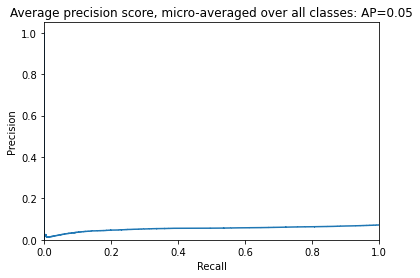

In [72]:
get_precision_score(dmi_matrix, result_ma)

In [73]:
from sklearn.metrics import roc_curve, auc

In [74]:
def get_roc_curve(ori_matrix, pre_matrix):
        
    # For each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(dmi_matrix.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(ori_matrix[:, i], pre_matrix[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # A "micro-average": quantifying score on all classes jointly
    fpr["micro"], tpr["micro"], _ = roc_curve(ori_matrix.ravel(), pre_matrix.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print('ROC AUC: {0:0.2f}'.format(roc_auc["micro"]))
    
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ROC AUC: 0.39


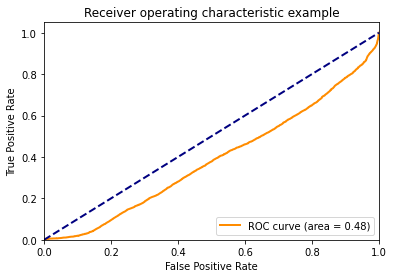

In [75]:
get_roc_curve(dmi_matrix, result_ma)

In [76]:
result_ma = covert_file_to_matrix('../results/MVMTMDA/4000_MDA.txt')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.07


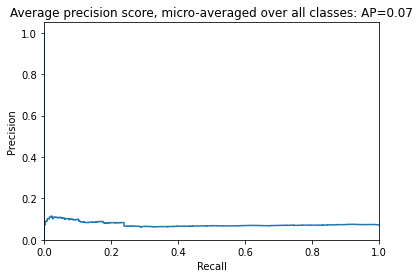

In [77]:
get_precision_score(dmi_matrix, result_ma)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ROC AUC: 0.49


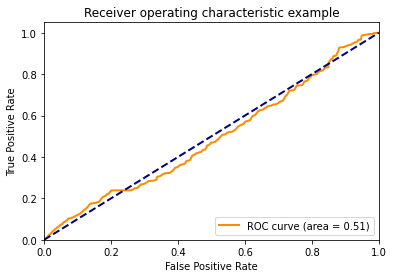

In [78]:
get_roc_curve(dmi_matrix, result_ma)